In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Loading collected data

projects = pd.read_csv('output/projects.csv')
steps = pd.read_csv('output/steps.csv')
topics = pd.read_csv('output/topics.csv')
tracks = pd.read_csv('output/tracks.csv')

## Projects analysis

In [4]:
# Grouping projects by language

projects_by_lang = {}
for lang in set(projects.language.values):
    projects_by_lang[lang] = projects[projects.language == lang]

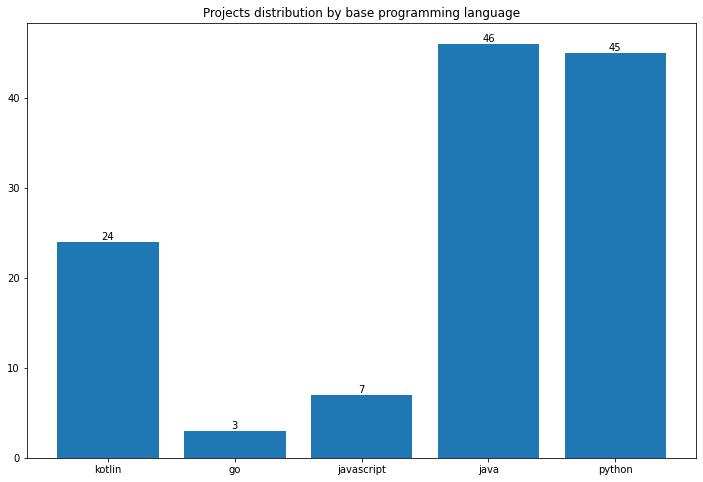

In [5]:
# Counting projects of each language

cnt_projects_by_lang = dict(zip(projects_by_lang.keys(), [len(prjs) for prjs in projects_by_lang.values()]))
lang_bars = plt.bar(projects_by_lang.keys(), cnt_projects_by_lang.values())
plt.bar_label(lang_bars, cnt_projects_by_lang.values())
plt.title("Projects distribution by base programming language")
plt.show()

According to the chart, most popular programming languages on the platform are *java* and *python* with nearly 50 projects, least popular are *javascript* and *go* with less than 10 projects. *Kotlin* takes the middle position as relatively new but versatile programming language.

## Steps analysis

In [6]:
def get_avg_like_rate(likes_stat):
    # Counts average score of step from likes statistic
    likes_sum = 0
    cnt = 0
    for stat in eval(likes_stat):
        likes_sum += stat['total_count'] * stat['value']
        cnt += stat['total_count']
    if cnt == 0:
        return 0
    return likes_sum / cnt

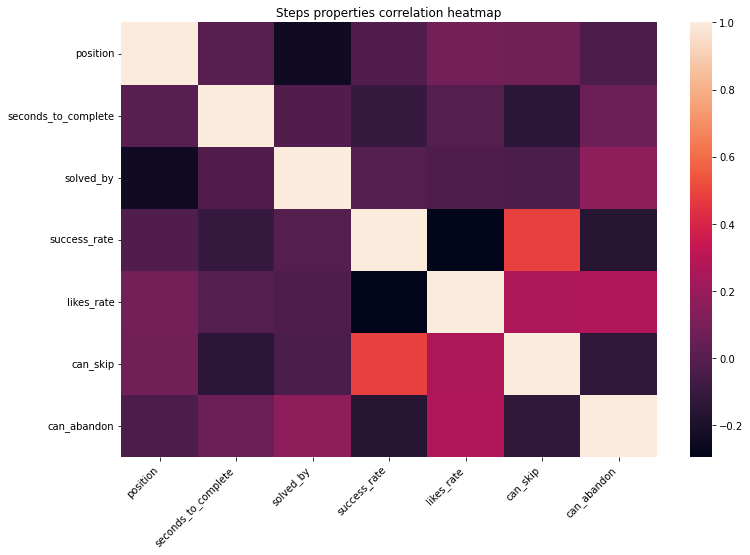

In [23]:
# Analyzing correlation of chosen properties of steps

steps_nona = steps[
    steps.position.notna() 
    & steps.seconds_to_complete.notna() 
    & steps.solved_by.notna() 
    & steps.success_rate.notna()
    & steps.likes_statistics.notna()
    & steps.can_skip.notna()
    & steps.can_abandon.notna()
]

properties = [
    'position',
    'seconds_to_complete',
    'solved_by',
    'success_rate',
    'likes_rate',
    'can_skip',
    'can_abandon'
         ]

heatmap = sns.heatmap(np.corrcoef(np.vstack([steps_nona.position.values, 
                       steps_nona.seconds_to_complete.values, 
                       steps_nona.solved_by.values, 
                       steps_nona.success_rate.values,
                       [get_avg_like_rate(likes_stat) for likes_stat in steps_nona.likes_statistics.values],
                       steps_nona.can_skip.values,
                       steps_nona.can_abandon.values])),
           xticklabels=properties, yticklabels=properties)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Steps properties correlation heatmap')
plt.show()

A significant correlation is observed between *success_rate* and *can_skip*. For detailed analysis one can consider the following boxplots' comparison.

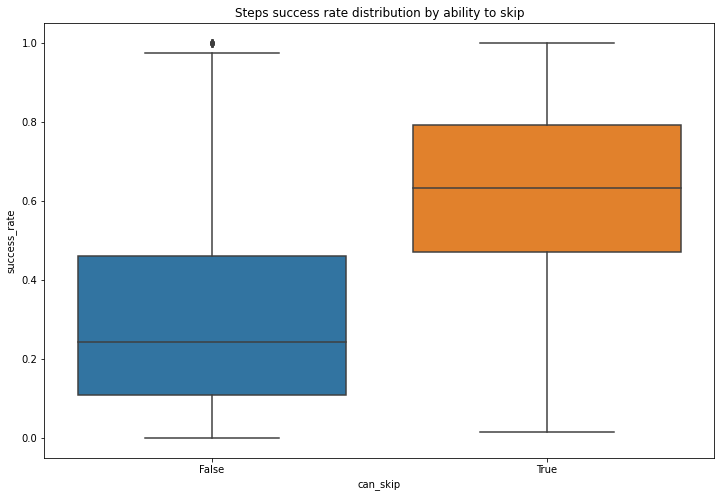

In [8]:
sns.boxplot(x='can_skip', y='success_rate', data=steps_nona)
plt.title('Steps success rate distribution by ability to skip')
plt.show()

It can be seen that in most cases *success_rate* for skippable steps is indeed significantly higher than for those that cannot be skipped.

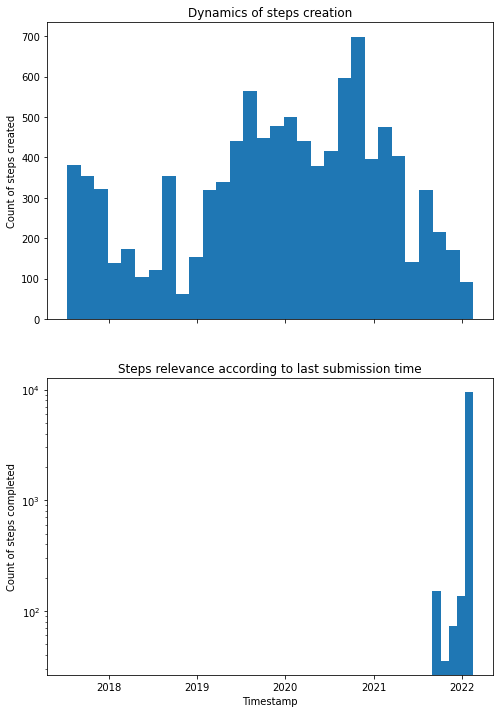

In [9]:
fig, (ax, bx) = plt.subplots(2, 1, sharex=True, figsize=(8,6 * 2))
ax.hist(pd.to_datetime(steps.content_created_at).values, bins=30)
bx.hist(pd.to_datetime(steps.last_completed_at.dropna()).values, bins=5, log=True)
ax.set_title('Dynamics of steps creation')
bx.set_title('Steps relevance according to last submission time')
plt.xlabel('Timestamp')
ax.set_ylabel('Count of steps created')
bx.set_ylabel('Count of steps completed')
plt.show()

According to the upper chart, since the end of 2020 there has been a decreasing trend in creating new steps on the platform. However, all steps remain relevant: all of them were solved during the last few months with overwhelming majority submitted in the last few days.

In [10]:
# Grouping steps by topic id

steps_with_topic = steps[steps.topic.notna()]
steps_by_topic = {}
for topic in set(steps_with_topic.topic.values):
    steps_by_topic[topic] = steps_with_topic[steps_with_topic.topic == topic]

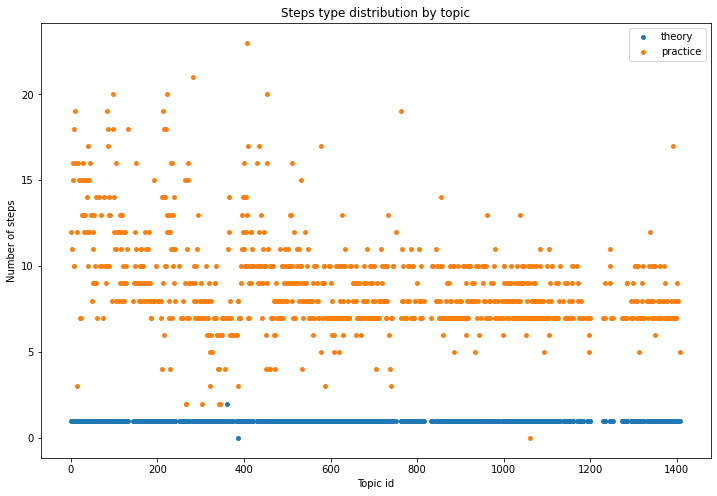

In [32]:
th_cnt_by_topic = dict(zip(steps_by_topic.keys(), [len(stps[stps.type == 'theory']) for stps in steps_by_topic.values()]))
pr_cnt_by_topic = dict(zip(steps_by_topic.keys(), [len(stps[stps.type == 'practice']) for stps in steps_by_topic.values()]))

plt.scatter(th_cnt_by_topic.keys(), th_cnt_by_topic.values(), label='theory', s=15)
plt.scatter(pr_cnt_by_topic.keys(), pr_cnt_by_topic.values(), label='practice', s=15)
plt.legend()
plt.title('Steps type distribution by topic')
plt.xlabel('Topic id')
plt.ylabel('Number of steps')
plt.show()

As can be seen from the plot, almost every topic has 1 theory step and 6-10 practice steps. Besides, topics with id less than 200 tend to have a little bit more practice steps than others. Also, there is only one topic among 10000 collected that has no practice steps.

## Topics analysis

In [12]:
def get_fstat_by_topic_id(topic_id, mean_secs):
    # Builds pandas DataFrame representing single row (topic_id, topic_title, mean_secs_to_complete)
    # by topic_id and mean_secs
    return pd.DataFrame({
        'topic_id': [topic_id],
        'topic_title': topics[topics.id == topic_id].title,
        'mean_secs_to_complete': [mean_secs]
    })

mean_step_secs_by_topic_top = sorted(zip([stps.seconds_to_complete.mean() for stps in steps_by_topic.values()], steps_by_topic.keys()), reverse=True)

table_top_topics = pd.DataFrame(columns=['topic_id', 'topic_title', 'mean_secs_to_complete'])

for m, topic in mean_step_secs_by_topic_top[:10]:
    tmp_df = get_fstat_by_topic_id(topic, m)
    table_top_topics = pd.concat([table_top_topics, tmp_df], ignore_index=True, axis=0)

table_top_topics.topic_id = table_top_topics.topic_id.astype('int')
print('======== Top 10 most time consuming topics ========')
display(table_top_topics)

======= Top 10 most time consuming topics =======


,topic_id,topic_title,mean_secs_to_complete
0,804,Bean validation,7283.627546
1,183,Regexes in programs,643.923936
2,12,Multidimensional array,633.210012
3,97,Iterating over arrays,595.453718
4,186,Match results,509.882126
5,935,BeautifulSoup: working with HTML,485.681439
6,763,Processing strings,468.093751
7,89,The for-loop,465.484587
8,1351,Comparator,461.692067
9,98,Processing strings,448.965527


Steps dedicated to 'Bean validation' take in average more than 7000 seconds, or almost 2 hours. That is an order of magnitude more than for subsequent topics in the top.

## Tracks analysis

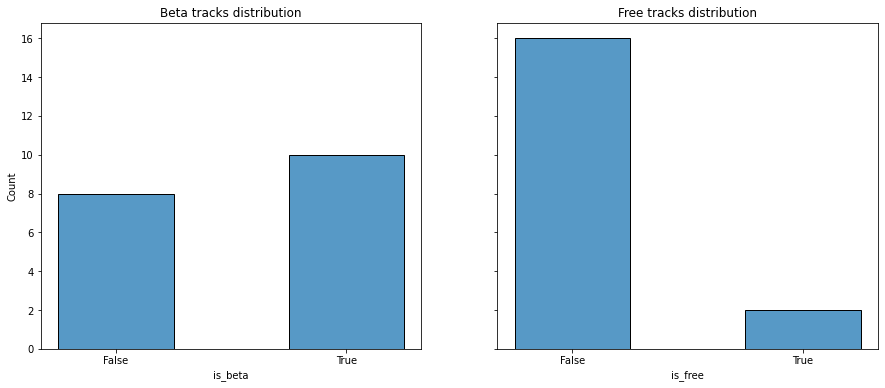

In [22]:
fig, (ax, bx) = plt.subplots(1, 2, sharey=True, figsize=(15,6))
sns.histplot(x=tracks.is_beta.astype('string'), shrink=0.5, ax=ax)
ax.set_title('Beta tracks distribution')
sns.histplot(x=tracks.is_free.astype('string'), shrink=0.5, ax=bx)
bx.set_title('Free tracks distribution')
plt.show()

More than a half of tracks on the platform are still represented as beta. However, that does not effect amount of free tracks, almost all of them must be paid to study.

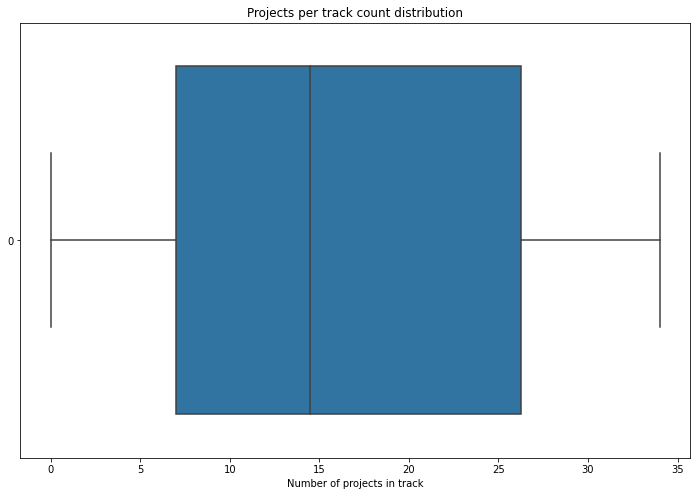

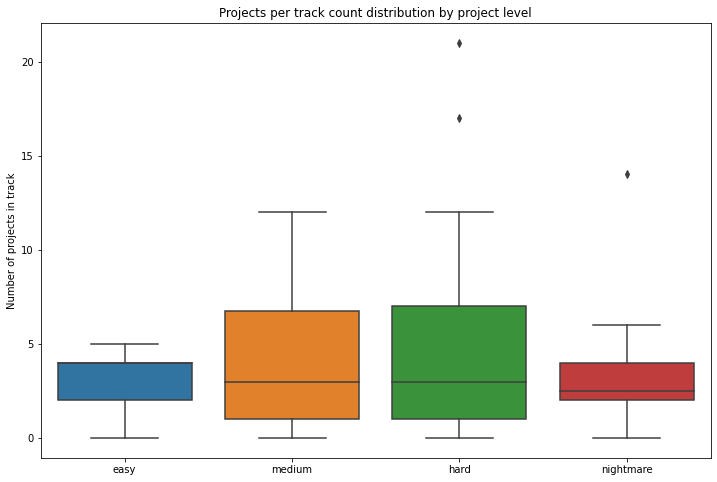

In [33]:
sns.boxplot(data=[len(eval(pr)) for pr in tracks.projects], orient='h')
plt.title('Projects per track count distribution')
plt.xlabel('Number of projects in track')
plt.show()

# Grouping tracks' projects by level

def get_pr_cnt_by_level(pr_by_level, level):
    pr_by_level = eval(pr_by_level)
    if level not in pr_by_level.keys():
        return 0
    return len(pr_by_level[level])

levels = ['easy', 'medium', 'hard', 'nightmare']

pr_by_level_plots = []
for level in levels:
    pr_by_level_plots.append([get_pr_cnt_by_level(pr, level) for pr in tracks.projects_by_level])
    
sns.boxplot(data=pr_by_level_plots, orient='v')
plt.xticks(plt.xticks()[0], levels)
plt.title('Projects per track count distribution by project level')
plt.ylabel('Number of projects in track')
plt.show()

Most of the tracks consist of 7 to 26 projects, where medium and hard ones prevail. Projects of 'easy' and 'nightmare' levels roughly match in number.